# PAMAP2 dataset

In [36]:
import numpy as np
import pandas as pd
from os import listdir
from numpy import genfromtxt
import matplotlib.pyplot as plt

In [37]:
%matplotlib inline

In [38]:
datadir = "/media/sf_VBox_Shared/timeseries/PAMAP2_Dataset/Protocol"
filenames = listdir(datadir)

axes = ['x', 'y', 'z']
IMUsensor_columns = ['temperature'] + \
                    ['acc_16g_' + i for i in axes] + \
                    ['acc_6g_' + i for i in axes] + \
                    ['gyroscope_'+ i for i in axes] + \
                    ['magnometer_'+ i for i in axes] + \
                    ['orientation_' + str(i) for i in range(4)]
header = ["timestamp", "activityID", "heartrate"] + ["hand_"+s for s in IMUsensor_columns]\
        + ["chest_"+s for s in IMUsensor_columns]+ ["ankle_"+s for s in IMUsensor_columns]
datasets = [pd.read_csv(datadir+'/'+fn, header=None, sep=' ') for fn in filenames]
for data in datasets:
    data.columns = header

data = datasets[0]    
print(data.shape)
print(header)

(376417, 54)
['timestamp', 'activityID', 'heartrate', 'hand_temperature', 'hand_acc_16g_x', 'hand_acc_16g_y', 'hand_acc_16g_z', 'hand_acc_6g_x', 'hand_acc_6g_y', 'hand_acc_6g_z', 'hand_gyroscope_x', 'hand_gyroscope_y', 'hand_gyroscope_z', 'hand_magnometer_x', 'hand_magnometer_y', 'hand_magnometer_z', 'hand_orientation_0', 'hand_orientation_1', 'hand_orientation_2', 'hand_orientation_3', 'chest_temperature', 'chest_acc_16g_x', 'chest_acc_16g_y', 'chest_acc_16g_z', 'chest_acc_6g_x', 'chest_acc_6g_y', 'chest_acc_6g_z', 'chest_gyroscope_x', 'chest_gyroscope_y', 'chest_gyroscope_z', 'chest_magnometer_x', 'chest_magnometer_y', 'chest_magnometer_z', 'chest_orientation_0', 'chest_orientation_1', 'chest_orientation_2', 'chest_orientation_3', 'ankle_temperature', 'ankle_acc_16g_x', 'ankle_acc_16g_y', 'ankle_acc_16g_z', 'ankle_acc_6g_x', 'ankle_acc_6g_y', 'ankle_acc_6g_z', 'ankle_gyroscope_x', 'ankle_gyroscope_y', 'ankle_gyroscope_z', 'ankle_magnometer_x', 'ankle_magnometer_y', 'ankle_magnometer_

In [45]:
print(len(datasets))
train_range = range(6)
val_range = [6]
test_range = range(7,len(datasets))

9


## Data exploration

In [39]:
#Copied from Jake VanderPlas, https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

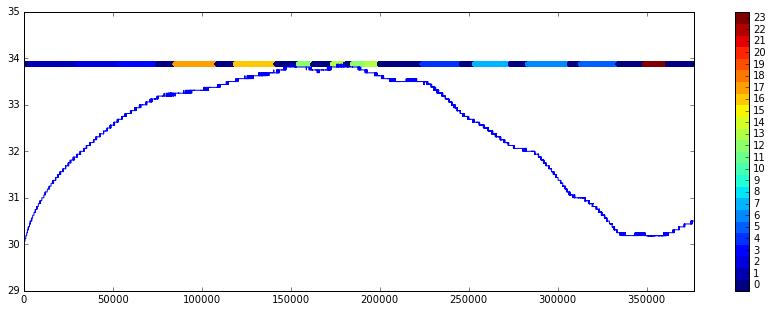

In [40]:
fig = plt.figure(figsize=(15,5))
labels = np.array(data.activityID)
nr_classes = max(labels)
labels_scaled = labels/nr_classes

data_to_plot = data.hand_temperature
plt.plot(data_to_plot)
plt.xlim(min(data.index), max(data.index))
#colors = [cma]
sca = plt.scatter(data.index, max(data_to_plot)*np.ones_like(labels), 
                  c=labels, cmap=discrete_cmap(nr_classes, 'jet'), edgecolors='none')
cax = plt.colorbar(sca, ticks=np.arange(np.min(labels),np.max(labels)+1))
plt.clim(-0.5, nr_classes - 0.5)
plt.show()

In [41]:
data.groupby('activityID').count()['timestamp']

activityID
0     126460
1      27187
2      23480
3      21717
4      22253
5      21265
6      23575
7      20265
12     15890
13     14899
16     22941
17     23573
24     12912
Name: timestamp, dtype: int64

## prepare dataset for keras

In [57]:
from keras.utils.np_utils import to_categorical

columns_to_use = ['hand_acc_16g_x', 'hand_acc_16g_y', 'hand_acc_16g_z',
                 'ankle_acc_16g_x', 'ankle_acc_16g_y', 'ankle_acc_16g_z',
                 'chest_acc_16g_x', 'chest_acc_16g_y', 'chest_acc_16g_z']

y_list = [np.array(data.activityID) for data in datasets]
classlabels = list(set.union(*[set(y) for y in y_list]))
nr_classes = len(classlabels)
mapclasses = {classlabels[i] : i for i in range(len(classlabels))}
y_list = [np.array([mapclasses[c] for c in y], dtype='int') for y in  y_list]

y_binary_list = [to_categorical(y, nr_classes) for y in y_list]
X_list = [np.array(data[columns_to_use]) for data in datasets]
print(X_list[0].shape, y_list[0].shape, y_binary_list[0].shape)

(376417, 9) (376417,) (376417, 13)


In [58]:
#Fill missing values
#
for X in X_list:
    print(np.isnan(X).sum())
    X[np.isnan(X)] = 0

9870
16683
3696
10584
11499
8208
8400
16230
189


In [60]:
nr_samples = len(X_list)
sequence_length, nr_channels = X_list[0].shape
print(sequence_length, nr_channels, nr_classes)

376417 9 13


In [63]:
for X in X_list:
    print(X.shape)

(376417, 9)
(447000, 9)
(252833, 9)
(329576, 9)
(374783, 9)
(361817, 9)
(313599, 9)
(408031, 9)
(8477, 9)


## Construct batches

In [64]:
nr_batches_per_series = 1000
batch_length = 100
nr_batches = nr_batches_per_series * len(train_range)

X_batches = np.zeros((nr_batches, batch_length, nr_channels))
y_batches_binary = np.zeros((nr_batches, batch_length, nr_classes))
y_batches_last_binary = np.zeros((nr_batches, nr_classes))

for j in train_range:
    for i in range(nr_batches_per_series):
        k = j*nr_batches_per_series + i
        X = X_list[j]
        y_binary = y_binary_list[j]
        start = np.random.randint(X.shape[0]-batch_length)
        X_batches[k,:,:] = X[start:start+batch_length,:]
        y_batches_binary[k,:,:] = y_binary[start:start+batch_length, :]
        y_batches_last_binary[k,:] = y_binary[start+batch_length-1, :]

In [29]:
#Test and validation 

(5000, 100, 9) (5000, 100, 13)


## Keras model

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Lambda, Convolution2D, Flatten, Reshape, LSTM, Dropout, TimeDistributed, Permute
from keras.regularizers import l2

In [31]:
dim_length = batch_length
dim_channels = nr_channels

input_shape = (dim_length, dim_channels)
num_filters = [64, 64, 64, 64]
lstm_dims = [128, 128]
filter_size = 5

In [32]:
model = Sequential()
model.add(Reshape(target_shape=(1, dim_length, dim_channels), input_shape=input_shape))
for i in range(len(num_filters)):
    model.add(Convolution2D(num_filters[i], 
                        nb_row=filter_size, 
                        nb_col=1, 
                        border_mode='same', W_regularizer=l2(0.01)))
    model.add(Activation('relu')) 


model.add(Reshape(target_shape=(dim_length, num_filters[-1]*dim_channels)))

model.add(LSTM(output_dim=lstm_dims[0], return_sequences=True, 
              activation='tanh'))
model.add(LSTM(output_dim=lstm_dims[1], 
               #return_sequences=False, #This takes the output of the last one in the sequence
               return_sequences=True,
              activation='tanh')) 

model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(nr_classes)))
#model.add(Dense(nr_classes))
model.add(Activation("softmax")) # Final classification layer - per timestep
model.add(Lambda(lambda x: x[:,-1,:], output_shape=[nr_classes]))

In [33]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
reshape_6 (Reshape)                (None, 1, 100, 9)   0           reshape_input_3[0][0]            
____________________________________________________________________________________________________
convolution2d_9 (Convolution2D)    (None, 64, 100, 9)  384         reshape_6[0][0]                  
____________________________________________________________________________________________________
activation_10 (Activation)         (None, 64, 100, 9)  0           convolution2d_9[0][0]            
____________________________________________________________________________________________________
convolution2d_10 (Convolution2D)   (None, 64, 100, 9)  20544       activation_10[0][0]              
___________________________________________________________________________________________

In [34]:
from keras.optimizers import RMSprop
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001, rho=0.9), metrics=['accuracy'])

In [35]:
model.fit(X_batches, y_batches_last_binary, nb_epoch=10, validation_split=0.7)

Train on 1500 samples, validate on 3500 samples
Epoch 1/10
1500/1500 [==============================] - 91s - loss: 3.9862 - acc: 0.4687 - val_loss: 1.5113 - val_acc: 0.5437
Epoch 2/10
1500/1500 [==============================] - 89s - loss: 2.3255 - acc: 0.5993 - val_loss: 1.0779 - val_acc: 0.6606
Epoch 3/10
1500/1500 [==============================] - 96s - loss: 1.6198 - acc: 0.6613 - val_loss: 0.9831 - val_acc: 0.7031
Epoch 4/10
1500/1500 [==============================] - 90s - loss: 1.3595 - acc: 0.6920 - val_loss: 1.0031 - val_acc: 0.6757
Epoch 5/10
1500/1500 [==============================] - 91s - loss: 1.1943 - acc: 0.7027 - val_loss: 0.9081 - val_acc: 0.7177
Epoch 6/10
1500/1500 [==============================] - 91s - loss: 1.0594 - acc: 0.7327 - val_loss: 0.7370 - val_acc: 0.7660
Epoch 7/10
1500/1500 [==============================] - 90s - loss: 0.9401 - acc: 0.7573 - val_loss: 0.7657 - val_acc: 0.7586
Epoch 8/10
1500/1500 [==============================] - 106s - loss: 0